In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [3, 3]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED) # use for reproducibility

In [4]:
!ls ../mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [5]:
PATH_TO_DATA = os.path.join("..", "mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
# test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz")) # assume this doesn't exist

In [6]:
X, y = train_data['xs'], train_data['ys']
X_val, y_val = val_data['xs'], val_data['ys']

In [7]:
print("Train: ")
print("X:", X.shape, X.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print("y:", y.shape, y.dtype)

print("\nValidation: ")
print("X_val:", X_val.shape, X_val.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print("y_val:", y_val.shape, y_val.dtype)

Train: 
X: (80000, 3072) uint8
y: (80000,) uint8

Validation: 
X_val: (10000, 3072) uint8
y_val: (10000,) uint8


In [8]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH*3, )

# classes_and_names.csv
CLASS_NAMES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASS_COUNT = len(CLASS_NAMES)

In [9]:
def unflatten(flat_img):
    ''' Reverts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(IMG_SHAPE)

In [10]:
def show_image(img_index, X, y, figsize=None):
    ''' Shows the image represented by img_index-th row of X '''
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unflatten(X[img_index]))
    plt.title(f'idx #{img_index} ({CLASS_NAMES[y[img_index]]})')
    plt.axis(False)
    plt.show()

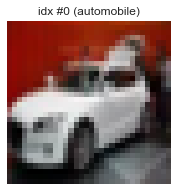

In [11]:
show_image(0, X, y)

In [12]:
y.shape

(80000,)

In [13]:
def onehot_encode(y):
    n_examples, *_ = y.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[:, y] = 1
    return onehot

In [14]:
onehot_y = onehot_encode(y) # makes y a onehot encoded vector
onehot_y_val = onehot_encode(y_val)

In [15]:
print("Train: ")
print("onehot_y:", onehot_y.shape, onehot_y.dtype)

print("\nValidation: ")
print("onehot_y_val:", onehot_y_val.shape, onehot_y_val.dtype)

Train: 
onehot_y: (80000, 10) float64

Validation: 
onehot_y_val: (10000, 10) float64


In [16]:
def z_score_normalized(X, eps=1e-12):
    mu = np.mean(X)
    sigma = np.std(X)
    return (X - mu) / (sigma if sigma != 0 else eps)

In [17]:
normalized_X = z_score_normalized(X)
normalized_X_val = z_score_normalized(X_val)

print("mean:", np.mean(normalized_X), "std:", np.std(normalized_X))
print("mean:", np.mean(normalized_X_val), "std:", np.std(normalized_X_val))

mean: 3.145816940275381e-17 std: 0.9999999999999993
mean: 5.884922179196413e-17 std: 0.9999999999999993


In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
def h_theta(theta, X):
    z = X.dot(theta)
    return sigmoid(z)

In [20]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [21]:
def log(z, eps=1e-32):
    return np.log(np.maximum(z, eps))

def binary_cross_entropy(theta, X, y):
    y_pred = h_theta(theta, X)
    return -y*log(y_pred) - (1 - y)*log(1 - y_pred)

In [22]:
def loss_function(theta, X, y):
    return binary_cross_entropy(theta, X, y).mean()

In [23]:
def shuffled_X_y(X, y, seed):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    p = np.random.permutation(m)
    return X[p], y[p]

In [24]:
''' Returns a (n+1) x 1 array with the gradient values for each theta_j. '''
def eval_gradient(theta, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    
    m = X.shape[0]
    y_pred = h_theta(theta, X)
    
    # gradient for every theta (an array with each j-th element being the partial derivative of J with respect to theta_j)
    return (1 / m) * X.T.dot(y_pred - y)

In [25]:
''' Returns a (n+1) x 1 array with the updated values for each parameter theta_j. 

    If batch_size is specified, acts as a Mini Batch GD, otherwise, it works like Vanilla GD.

    Assumes that 'X' is a matrix with shape=(n_examples, n_features), with a first column of 1's, and that
    'y' is an array of shape=(n_examples, 1) with the corresponding target values for each row of 'X'.
    
    n_examples = m
    n_features = n+1 (x_0 = 1 for every row i in [1, m], i.e. X[i, 0] = 1)
'''
def batch_GD_step(theta, X, y, learning_rate, batch_size=None):
    if not batch_size:
        # vanilla
        theta_grad = eval_gradient(theta, X, y)
        theta -= learning_rate * theta_grad
    else:
        # mini batch
        X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
        for batch_X, batch_y in get_batches(X, y, batch_size):
            theta_grad = eval_gradient(theta, batch_X, batch_y)
            theta -= learning_rate * theta_grad
    return theta

## Gradient Descent Loop

In [41]:
def get_randomly_initialized_theta(n_features, rand_seed=RANDOM_SEED):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2 / (n_features + 1))
    return sigma * rand.randn(n_features, CLASS_COUNT)

def get_zero_initialized_theta(n_features):
    return np.zeros(shape=(n_features, CLASS_COUNT))

In [42]:
rand_theta = get_randomly_initialized_theta(n_features=IMG_FLAT_SHAPE[0])

In [46]:
import time

start = time.time()
batch_GD_step(rand_theta, normalized_X, onehot_y, learning_rate=0.001, batch_size=None)
vec_elapsed = time.time() - start

print(f'elapsed time for vectorized gradient descent step: {vec_elapsed:.4f}s')

elapsed time for vectorized gradient descent step: 1.0107s
